In [1]:
# %pip uninstall envirocar-py -y
# %pip install overpass

Min X: 7.62918783
Min Y: 51.95400748
Max X: 7.65293855
Max Y: 51.95982125
ele is not a valid column in input nodes. Ignoring this column.
timestamp is not a valid column in input nodes. Ignoring this column.
sat is not a valid column in input nodes. Ignoring this column.


<Axes: >

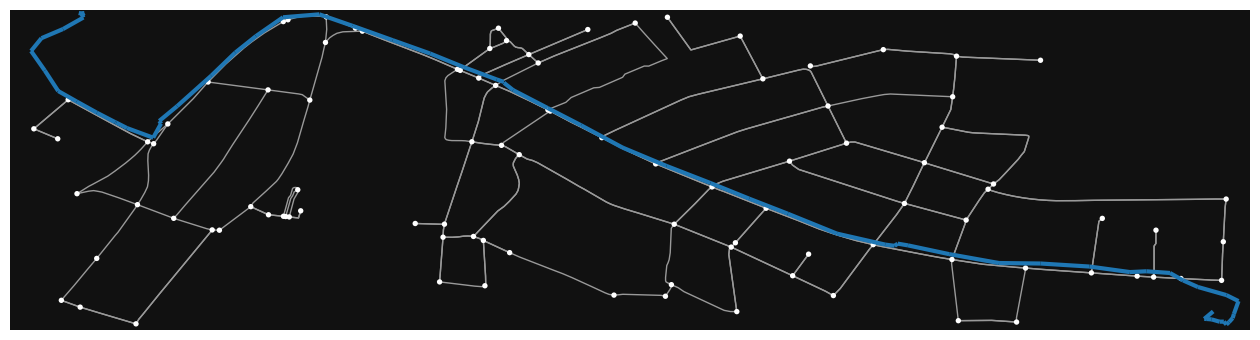

In [2]:
# %load_ext autoreload
# %autoreload 2

# load dependencies'
import concurrent.futures
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import osmnx as ox
import networkx as nx

import requests
import json
from urllib.parse import urljoin

from algorithms import mm_utils

# class HttpFailedException(Exception):
#     """ General exception raised whenever communication failes """

# class NotFoundException(HttpFailedException):
#     """ Exception raised whenever a certain resource has not been found """

# class NotAuthorizedException(HttpFailedException):
#     """ Exception raised whenever the user doesn't has the rights to access a certain resource """

# class MailNotConfirmedException(HttpFailedException):
#     """ Exception raised whenever the user hasn't confirmed his mail """

# class ECConfig:

#     class _ECConfig:
#         CONFIG_PARAMS = {
#             "ec_base_url": "https://envirocar.org/api/stable/",
#             "ec_username": "",
#             "ec_password": "",
#             "number_of_processes": 4
#         }

#         def __init__(self):
#             self.load_config()

#         def load_config(self):
#             for key, value in self.CONFIG_PARAMS.items():
#                 setattr(self, key, value)

#     _instance = None

#     def __init__(self):
#         if not ECConfig._instance:
#             ECConfig._instance = self._ECConfig()
#         for item in ECConfig._instance.CONFIG_PARAMS:
#             setattr(self, item, getattr(ECConfig._instance, item))
            
# class BboxSelector:
#     """ Class for creating bounding box requests """

#     def __init__(self, bbox: [float]):
#         self.min_x = bbox[0]
#         self.min_y = bbox[1]
#         self.max_x = bbox[2]
#         self.max_y = bbox[3]

#     @property
#     def lower_left(self):
#         return self.min_x, self.min_y

#     @property
#     def upper_right(self):
#         return self.max_x, self.max_y

#     @property
#     def param(self):
#         return { 'bbox': f'{self.min_x},{self.min_y},{self.max_x},{self.max_y}' }

# class TimeSelector:
#     def __init__(self, start_time=None, end_time=None):
#         self.start_time = start_time
#         self.end_time = end_time

#     @property
#     def param(self):
#         if self.start_time and self.end_time==None:
#             return { 'after': f'{self.start_time}' }
#         elif self.start_time==None and self.end_time:
#             return { 'before': f'{self.end_time}' }
#         elif self.start_time and self.end_time:
#             return { 'during': f'{self.start_time},{self.end_time}' }


# class RequestParam:
#     def __init__(self, path: str, method="GET", headers=None, params=None):
#         self.path = path
#         self.method = method
#         self.headers = headers or []
#         self.params = params or []
        
# def handle_error_status(http_download):
#     """Decorating function for handling enviroCar HTTP exceptions
    
#     Arguments:
#         http_download {function} -- function to wrap
    
#     Raises:
#         HttpFailedException: wrapper for client exceptions
#         exception: other exceptions
    
#     Returns:
#         function -- decorated function
#     """
#     def decorate(self, request: RequestParam):
#         try:
#             return http_download(self, request)
#         except requests.HTTPError as exception:
#             if exception.response.status_code < requests.codes['internal_server_error']:
#                 if exception.response.status_code == requests.codes['unauthorized']:
#                     message = "Unauthorized to access: {}".format(request.path)
#                     raise NotAuthorizedException(message)
#                 else: 
#                     message = "Failed to download from: {}".format(request.path)
#                     raise HttpFailedException(message) from exception
#             raise exception from exception
#     return decorate

# class DownloadClient:

#     def __init__(self, *, config=None):
#         self.config = config or ECConfig()

#     def download(self, download_requests, decoder=None):
#         if (isinstance(download_requests, RequestParam)):
#             download_requests = [download_requests]

#         with concurrent.futures.ThreadPoolExecutor(max_workers=self.config.number_of_processes) as executor:
#             download_list = [executor.submit(self._download, request) for request in download_requests]

#         result_list = []
#         for future in download_list:
#             try:
#                 decoded_data = future.result().decode('utf-8')
#                 result_list.append(decoded_data)
#             except HttpFailedException as e:
#                 warnings.warn(str(e))
#                 result_list.append(None)

#         if decoder:
#             return decoder(result_list)
#         return result_list

#     @handle_error_status
#     def _download(self, download_request: RequestParam):
#         url = urljoin(self.config.ec_base_url, download_request.path)
#         print('self.config.ec_base_url', self.config.ec_base_url)
#         print('download_request', download_request.path)
        
#         # set BasicAuth parameters
#         auth = None
#         if self.config.ec_username and self.config.ec_password:
#             auth = HTTPBasicAuth(self.config.ec_username, self.config.ec_password)

#         response = requests.request(
#             download_request.method,
#             url= url,
#             auth=auth,
#             headers=download_request.headers,
#             params=download_request.params
#         )

#         response.raise_for_status()
#         # LOG.info("Successfully downloaded %s", url)
#         return response.content

# class TrackAPI():
#     """Handles the API access to the enviroCar backend and returns queried results as dataframes"""
#     TRACKS_ENDPOINT = "tracks"
#     TRACK_ENDPOINT = "tracks/{}"
#     USERTRACKS_ENDPOINT = "users/{}/tracks"

#     def __init__(self, api_client=None):
#         self.api_client = api_client or DownloadClient()

#     def get_tracks(self, username=None, bbox:BboxSelector=None, time_interval:TimeSelector=None, num_results=10, page_limit=100):
#         """Handles queries against the enviroCar api

#         Keyword Arguments:
#             username {str} -- the username to request tracks for (default: {None})
#             bbox {BboxSelector} -- bbox query parameter (default: {None})
#             time_interval {TimeSelector} -- time interval query parameter (default: {None})
#             num_results {int} -- maximum number of tracks to request (default: {10})
#             page_limit {int} -- page limit (default: {100})

#         Returns:
#             GeoDataFrame -- A GeoDataFrame containing the tracks matching the request parameters
#         """
#         path = self._get_path(username=username)

#         # creating download_requests
#         download_requests = []
#         current_results = 0
#         current_page = 1
#         while current_results < num_results:
#             request_params = {
#                 'limit': page_limit,
#                 'page': current_page
#             }
#             if bbox:
#                 request_params.update(bbox.param)

#             if time_interval:
#                 request_params.update(time_interval.param)

#             request = RequestParam(path=path, params=request_params)
#             download_requests.append(request)

#             current_results += page_limit
#             current_page += 1

#         # request for /tracks
#         tracks_meta_df = self.api_client.download(download_requests, decoder=_parse_tracks_list_df)
#         tracks_meta_df = tracks_meta_df[:num_results]

#         if not tracks_meta_df.empty:
#             ids = tracks_meta_df['track.id'].values
#             tracks_df = self._get_tracks_by_ids(ids)
#             return tracks_df

#         return gpd.GeoDataFrame()

#     def get_track(self, track_id: str):
#         return self.api_client.download(
#             RequestParam(path=self._get_path(trackid=track_id)),
#             decoder=_parse_track_df)

#     def _get_tracks_by_ids(self, ids: [str]):
#         download_requests = [RequestParam(path=self._get_path(trackid=id)) for id in ids]
#         return self.api_client.download(download_requests, decoder=_parse_track_df)

#     def _get_path(self, *, username=None, trackid=None):
#         if username is None and trackid is None:
#             return self.TRACKS_ENDPOINT
#         if username:
#             return self.USERTRACKS_ENDPOINT.format(username)
#         if trackid:
#             return self.TRACK_ENDPOINT.format(trackid)

# def _parse_tracks_list_df(tracks_jsons):
#     if not isinstance(tracks_jsons, list):
#         tracks_jsons = [tracks_jsons]

#     tracks_meta_df = pd.DataFrame()
#     for tracks_json in tracks_jsons:
#         if tracks_json:
#             ec_data = json.loads(tracks_json)
#             df = pd.json_normalize(ec_data, 'tracks')
#             df.rename(columns=__rename_track_columns, inplace=True)
#             # tracks_meta_df = tracks_meta_df.append(df)
#             tracks_meta_df = tracks_meta_df.add(df)

#     return tracks_meta_df

# def _parse_track_df(track_jsons):
#     if not isinstance(track_jsons, list):
#         track_jsons = [track_jsons]

#     tracks_df = gpd.GeoDataFrame()
#     for track_json in track_jsons:
#         # read properties
#         car_df = pd.json_normalize(json.loads(track_json)['properties'])
#         car_df.columns = car_df.columns.str.replace('sensor.properties.', 'sensor.')
#         car_df.rename(columns=__rename_track_columns, inplace=True)

#         # read geojson values
#         track_df = gpd.read_file(track_json)
#         track_df = track_df.join(pd.json_normalize(track_df['phenomenons'])).drop(['phenomenons'], axis=1)

#         # combine dataframes
#         car_df = pd.concat([car_df]*len(track_df.index), ignore_index=True)
#         # tracks_df = tracks_df.append(track_df.join(car_df))
#         tracks_df = tracks_df.add(track_df.join(car_df))

#     return tracks_df

# def __rename_track_columns(x):
#     if not x.startswith('sensor'):
#         return 'track.' + x
#     return x
        
# config = ECConfig()
# client = DownloadClient(config=config)
# track_api = TrackAPI(client)
# tracks = track_api.get_tracks(num_results=4, page_limit=3)
# print(tracks)

url = "https://envirocar.org/api/stable/tracks/52f3836be4b0d8e8c27ed6f0"
response = requests.get(url)
data = json.loads(response.text)

# attributes = dir(data)
# for attribute in attributes:
#     print(attribute)
#
# print(data)

geometries = []
attributes = []

for feature in data['features']:
    geometry = shape(feature['geometry'])
    geometries.append(geometry)
    attributes.append(feature['properties'])

gdf = gpd.GeoDataFrame(data=attributes, geometry=geometries)

# Get the bounding box
bbox = gdf.total_bounds

# 'total_bounds' returns a tuple with (minx, miny, maxx, maxy) values
minx, miny, maxx, maxy = bbox

# Print the bounding box values
print("Min X:", minx)
print("Min Y:", miny)
print("Max X:", maxx)
print("Max Y:", maxy)

G=nx.Graph()

#座標を指定し地図データをダウンロード
G = ox.graph.graph_from_bbox(maxy, miny, maxx, minx, network_type='drive')
fig, ax = ox.plot_graph(G, figsize = (16,16),show=False,close=False)

tripdata_edges = mm_utils.point_to_traj(gdf, columns = {'ele': 'average',
                                                                  'timestamp':'first',
                                                                  'sat':'first'})
tripdata_edges.plot(ax=ax, linewidth=3)

campus = ox.features.features_from_place('Somewhere', tags = {'name':True})
campus.plot(ax=ax, alpha=0.5)

# bbox_url = f'http://www.overpass-api.de/api/xapi?way[bbox={minx},{miny},{maxx},{maxy}][highway=*]'#.format(minx, miny, maxx, maxy)
# print(bbox_url)

# bbox_response = requests.get(bbox_url)
# print(bbox_response)
# attributes = dir(bbox_response)
# for attribute in attributes:
#     print(attribute)
    
# import overpass
# api = overpass.API(timeout=600)
# map_query = overpass.MapQuery(minx, miny, maxx, maxy)
# response = api.Get(map_query, responseformat="json")
# # response = api.get(f'node[bbox={minx},{miny},{maxx},{maxy}]')
# print(response)

# print(gdf)

# from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# # create an initial but optional config and an api client
# config = ECConfig()
# track_api = TrackAPI(api_client=DownloadClient(config=config))



# bbox = BboxSelector([
#     7.601165771484375, # min_x
#     51.94807412325402, # min_y
#     7.648200988769531, # max_x
#     51.97261482608728  # max_y
# ])

# # issue a query
# track_df = track_api.get_tracks(bbox=bbox, num_results=50) # requesting 50 tracks inside the bbox
# track_df

